In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [13]:
import torch 
import matplotlib.pyplot as plt

from train_large import config
from icecube_utils import (
    load_pretrained_model, 
    make_dataloaders,
)

In [7]:
size_multiplier = 2.0
to_dict_path = 'weights/test3_mapped/state_dict.pth'
from_dict_path = 'weights/test3/state_dict.pth'
act_num_samples = 200

config['dataset_type'] = 'sqlite'
config['train_mode'] = 'default'

In [5]:
model_from = load_pretrained_model(
    config=config, 
    path=from_dict_path
)

config['dynedge']['dynedge_layer_sizes'] = [
    (int(x * size_multiplier), int(y * size_multiplier)) 
    for x, y in [(128, 256), (336, 256), (336, 256), (336, 256)]
]
model_to = load_pretrained_model(
    config=config, 
    path=to_dict_path
)

graphnet: INFO     2023-04-09 17:46:40 - load_pretrained_model - Current model state dict keys: odict_keys(['_gnn._conv_layers.0.nn.0.linear.weight', '_gnn._conv_layers.0.nn.0.linear.bias', '_gnn._conv_layers.0.nn.0.bn.weight', '_gnn._conv_layers.0.nn.0.bn.bias', '_gnn._conv_layers.0.nn.0.bn.running_mean', '_gnn._conv_layers.0.nn.0.bn.running_var', '_gnn._conv_layers.0.nn.0.bn.num_batches_tracked', '_gnn._conv_layers.0.nn.1.linear.weight', '_gnn._conv_layers.0.nn.1.linear.bias', '_gnn._conv_layers.0.nn.1.bn.weight', '_gnn._conv_layers.0.nn.1.bn.bias', '_gnn._conv_layers.0.nn.1.bn.running_mean', '_gnn._conv_layers.0.nn.1.bn.running_var', '_gnn._conv_layers.0.nn.1.bn.num_batches_tracked', '_gnn._conv_layers.1.nn.0.linear.weight', '_gnn._conv_layers.1.nn.0.linear.bias', '_gnn._conv_layers.1.nn.0.bn.weight', '_gnn._conv_layers.1.nn.0.bn.bias', '_gnn._conv_layers.1.nn.0.bn.running_mean', '_gnn._conv_layers.1.nn.0.bn.running_var', '_gnn._conv_layers.1.nn.0.bn.num_batches_tracked', '_gnn._con

In [15]:
def normalize_tensor(tens):
    tens_shape = tens.shape
    assert tens_shape[1] == 1
    tens = tens.view(tens_shape[0], 1, -1)
    norms = tens.norm(dim=-1)
    ntens = tens/norms.view(-1, 1, 1)
    ntens = ntens.view(tens_shape)
    return ntens

def get_activations(models, train_loader, num_samples, mode='mean', standardize_acts=None, layer_names=None):
    torch.manual_seed(0)

    # hook that computes the mean activations across data samples
    def get_activation(activation, name):
        def hook(model, input, output):
            if name not in activation:
                activation[name] = []

            if isinstance(output, tuple):
                activation[name].append(output[0].detach())
            else:
                activation[name].append(output.detach())

        return hook

    # Prepare all the models
    activations = {}
    forward_hooks = []

    for idx, model in enumerate(models):

        # Initialize the activation dictionary for each model
        activations[idx] = {}
        layer_hooks = []
        
        # Set forward hooks for all layers inside a model
        for name, layer in model.named_modules():
            if name not in layer_names:
                continue
            layer_hooks.append(layer.register_forward_hook(get_activation(activations[idx], name)))

        forward_hooks.append(layer_hooks)
        
        # Set the model in train mode
        model.train()

    # Run the same data samples ('num_samples' many) across all the models
    num_samples_processed = 0
    for _, data in enumerate(train_loader):
        if num_samples_processed >= num_samples:
            break

        for idx, model in enumerate(models):
            model(data)

        num_samples_processed += len(data)

    # Combine the activations generated across the number of samples to form importance scores
    # The importance calculated is based on the 'mode' flag: which is either of 'mean', 'std', 'meanstd'

    # model_cfg = myutils.get_model_layers_cfg(args.model_name)
    for idx in range(len(models)):
        for lnum, layer in enumerate(activations[idx]):
            activations[idx][layer] = torch.concatenate(activations[idx][layer], dim=0)
                
            if mode == 'mean':
                activations[idx][layer] = activations[idx][layer].mean(dim=0)
            elif mode == 'std':
                activations[idx][layer] = activations[idx][layer].std(dim=0)
            elif mode == 'meanstd':
                activations[idx][layer] = activations[idx][layer].mean(dim=0) * activations[idx][layer].std(dim=0)

            if standardize_acts == 'standardize':
                mean_acts = activations[idx][layer].mean(dim=0)
                std_acts = activations[idx][layer].std(dim=0)
                activations[idx][layer] = (activations[idx][layer] - mean_acts)/(std_acts + 1e-9)
            elif standardize_acts == 'center':
                mean_acts = activations[idx][layer].mean(dim=0)
                activations[idx][layer] = (activations[idx][layer] - mean_acts)
            elif standardize_acts == 'normalize':
                activations[idx][layer] = normalize_tensor(activations[idx][layer])

    # Remove the hooks (as this was intefering with prediction ensembling)
    for idx in range(len(forward_hooks)):
        for hook in forward_hooks[idx]:
            hook.remove()

    return activations

In [16]:
train_dataloader, _ = make_dataloaders(config)

layer_names = {
    name.replace('.bias', '') 
    for name, _ in model_from.named_parameters()
    if '.bn.bias' in name or '_affine.bias' in name
}
with torch.no_grad():
    activations = get_activations(
        [model_from, model_to],
        train_dataloader,
        act_num_samples,
        mode='raw',
        layer_names=layer_names
    )

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will b

graphnet: INFO     2023-04-09 17:56:01 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.
graphnet: INFO     2023-04-09 17:56:04 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


_gnn._conv_layers.0.nn.0.bn [torch.Size([125349, 128]), torch.Size([125349, 256])]
_gnn._conv_layers.0.nn.0.bn [-1.1553272008895874, -0.8963038921356201]
_gnn._conv_layers.0.nn.0.bn [5.889033794403076, 8.615221977233887]
_gnn._conv_layers.0.nn.0.bn [1, 0.14494429528713226]

_gnn._conv_layers.0.nn.1.bn [torch.Size([125349, 256]), torch.Size([125349, 512])]
_gnn._conv_layers.0.nn.1.bn [-1.3945125341415405, -0.7198988795280457]
_gnn._conv_layers.0.nn.1.bn [8.0078763961792, 8.459749221801758]
_gnn._conv_layers.0.nn.1.bn [1, 0.18670554459095]

_gnn._conv_layers.1.nn.0.bn [torch.Size([124784, 336]), torch.Size([124784, 672])]
_gnn._conv_layers.1.nn.0.bn [-1.2618924379348755, -0.6373926401138306]
_gnn._conv_layers.1.nn.0.bn [6.947035312652588, 8.161884307861328]
_gnn._conv_layers.1.nn.0.bn [1, 0.177912637591362]

_gnn._conv_layers.1.nn.1.bn [torch.Size([124784, 256]), torch.Size([124784, 512])]
_gnn._conv_layers.1.nn.1.bn [-0.6517820954322815, -0.8661270141601562]
_gnn._conv_layers.1.nn.1.bn 

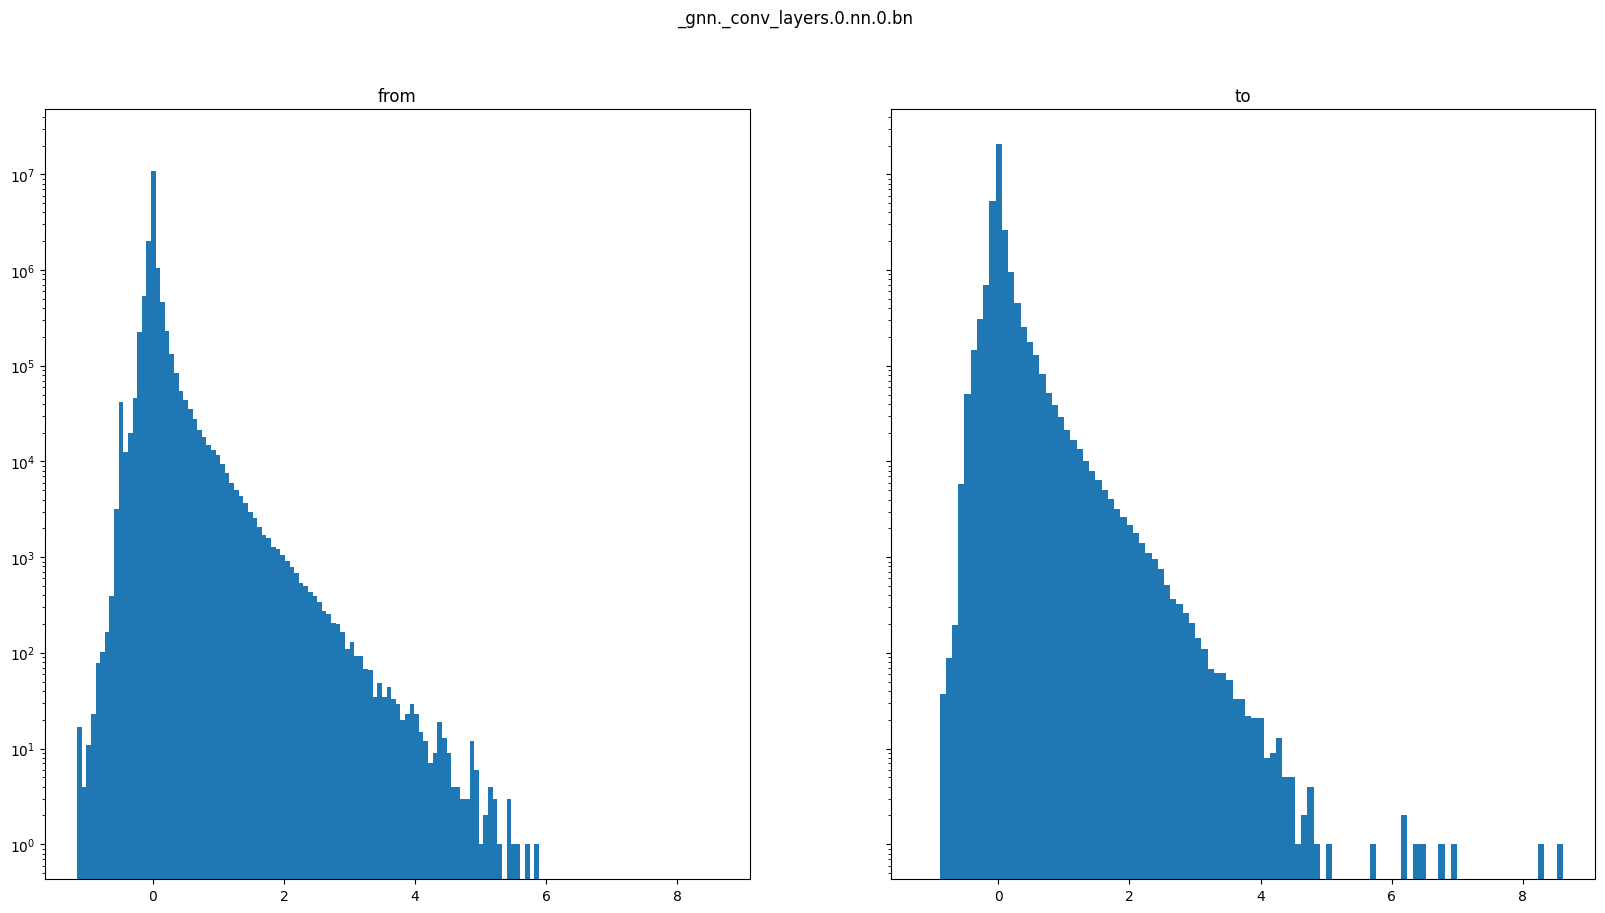

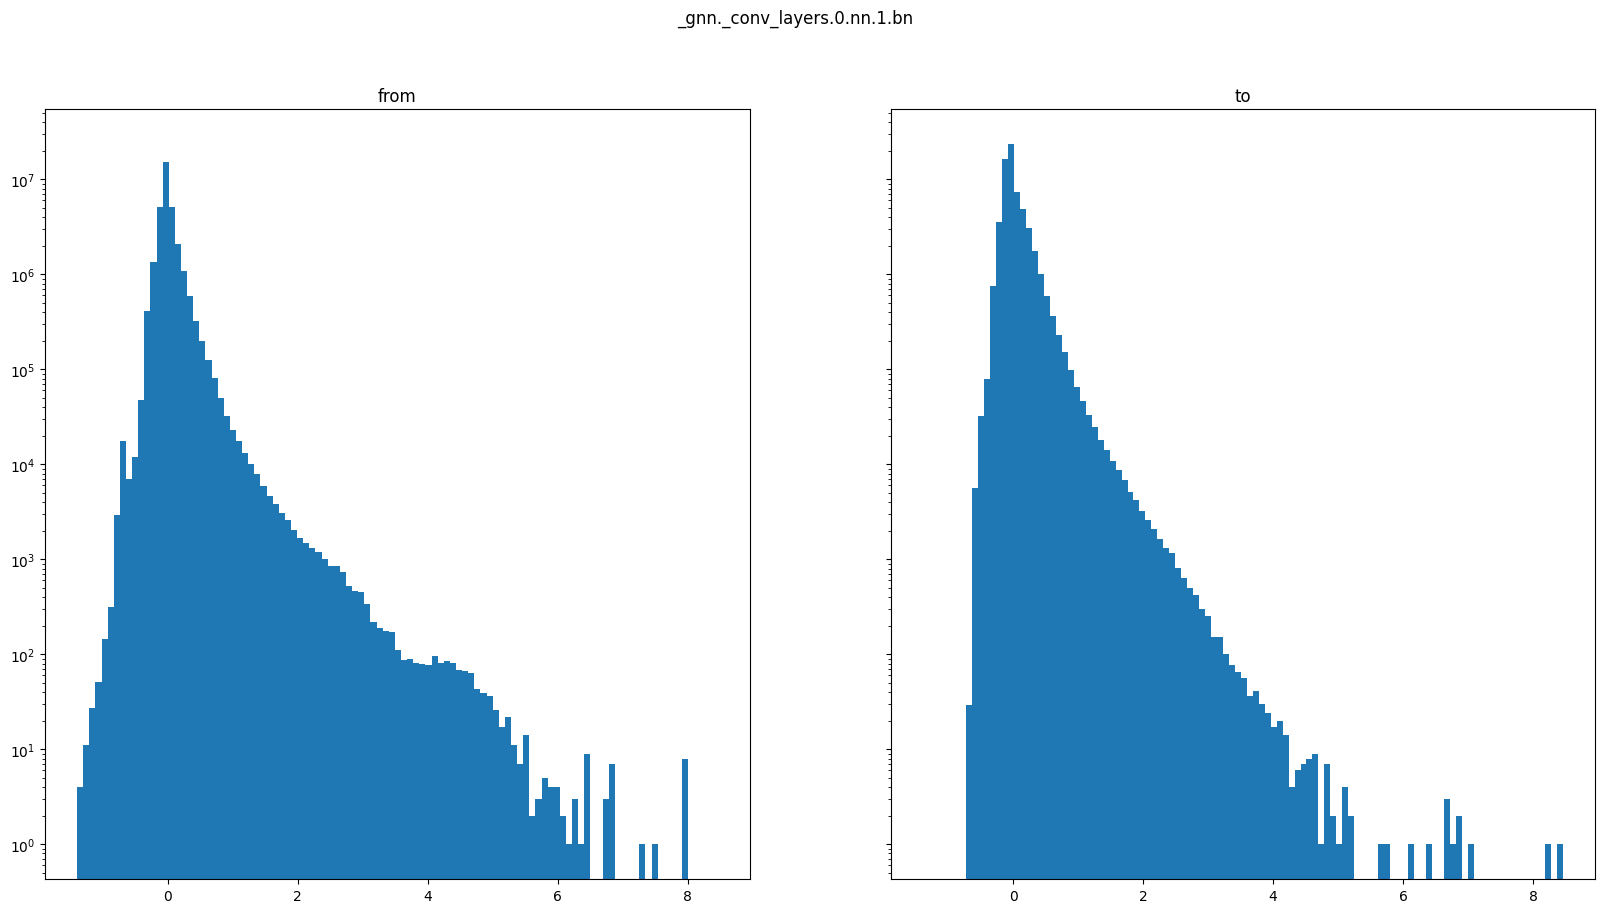

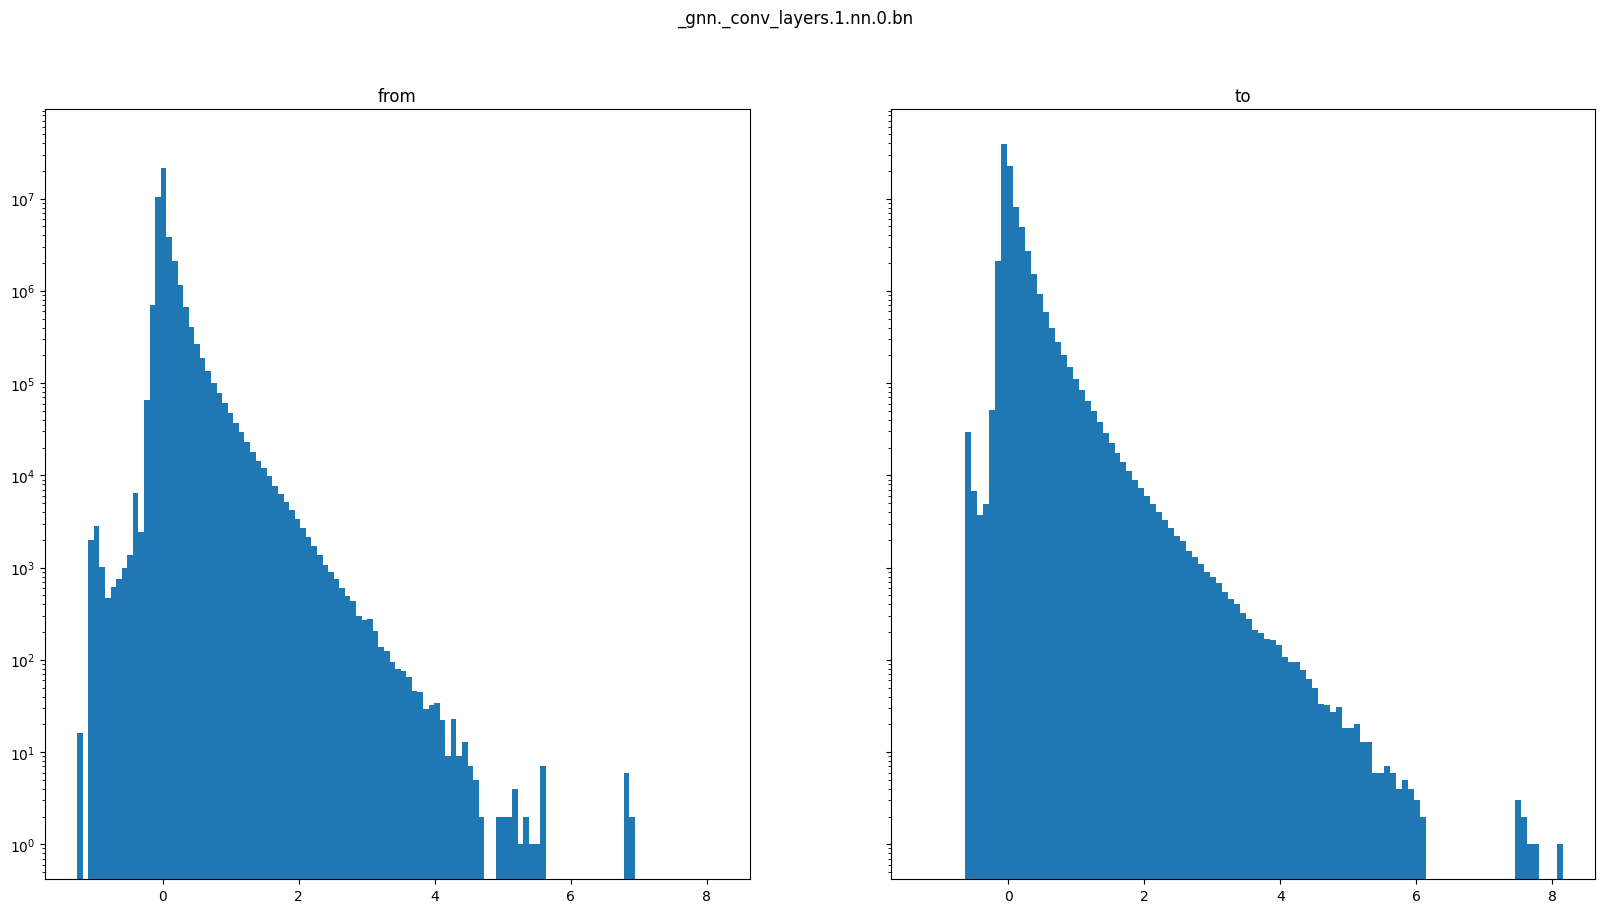

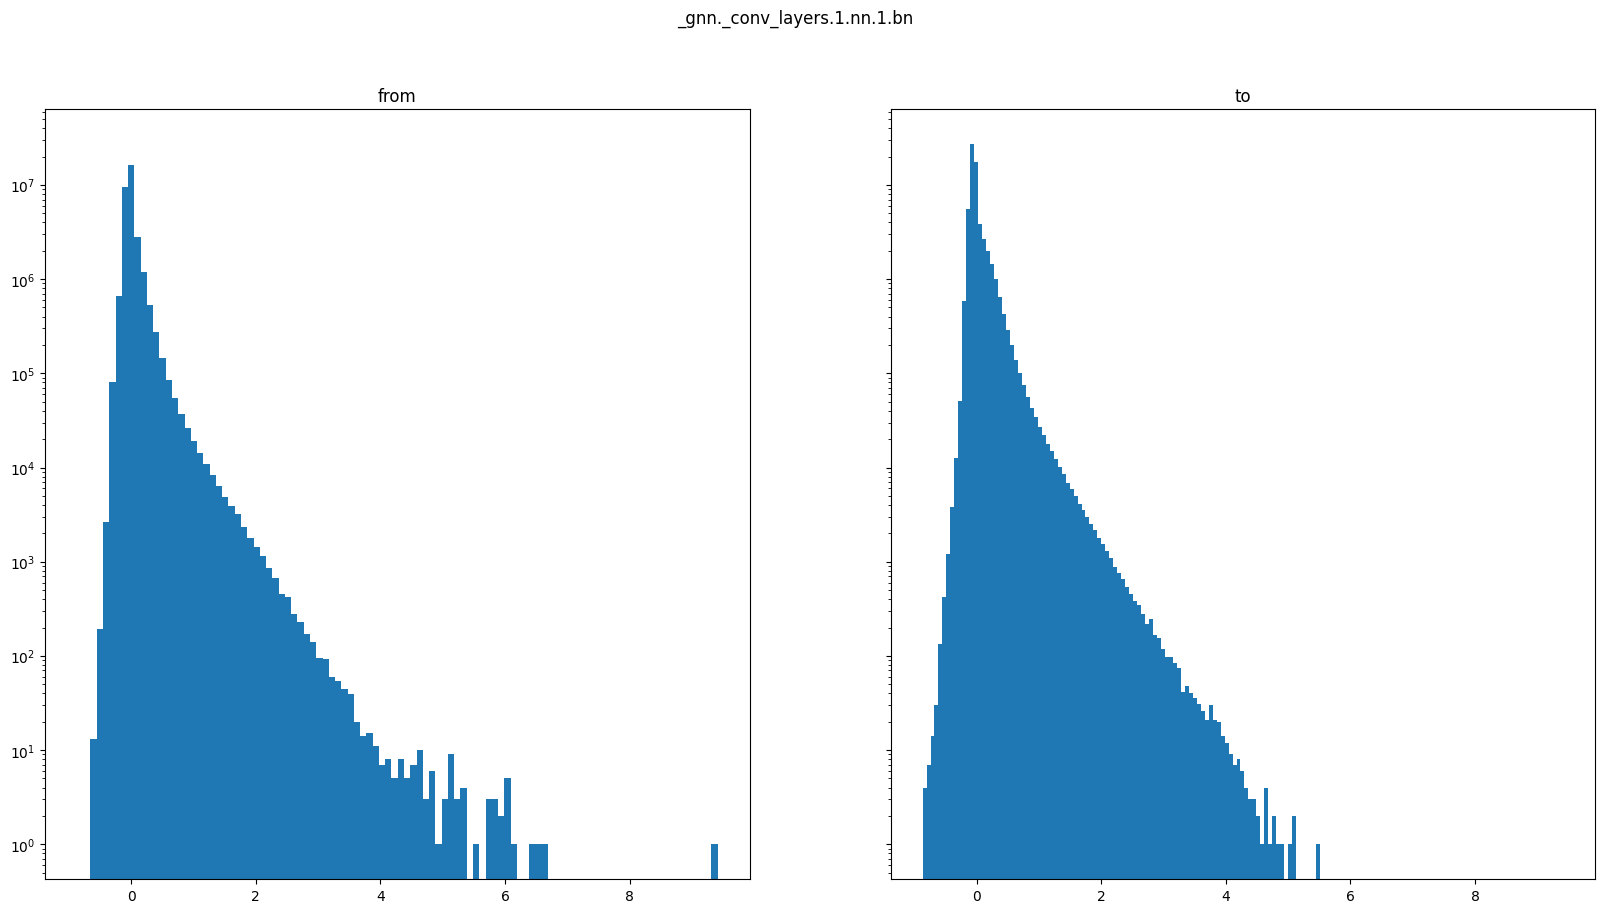

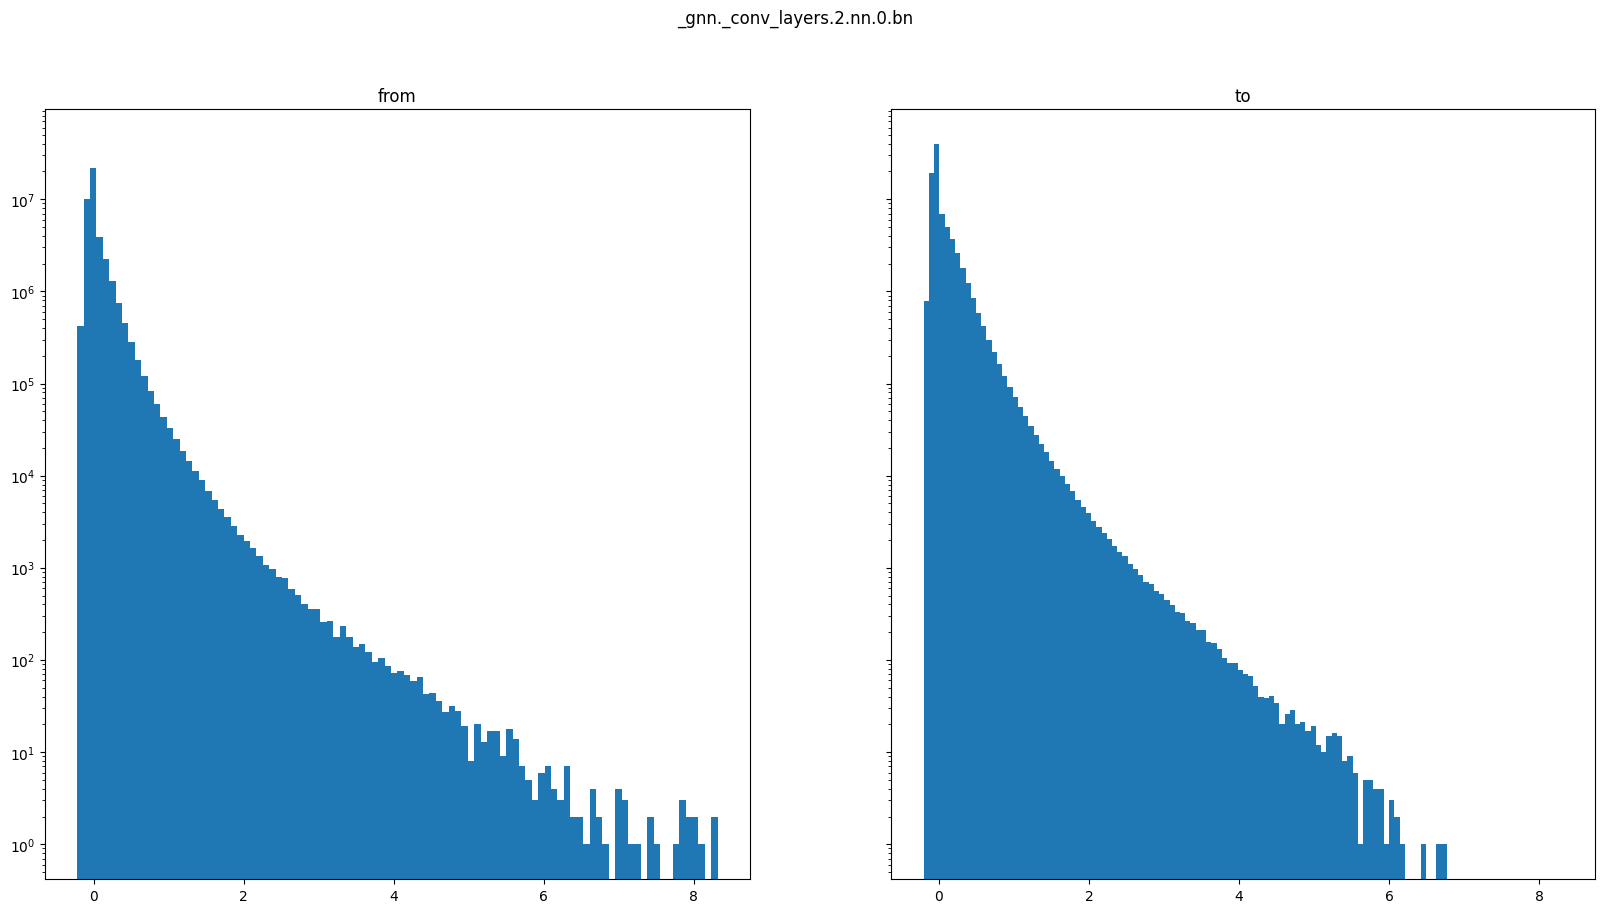

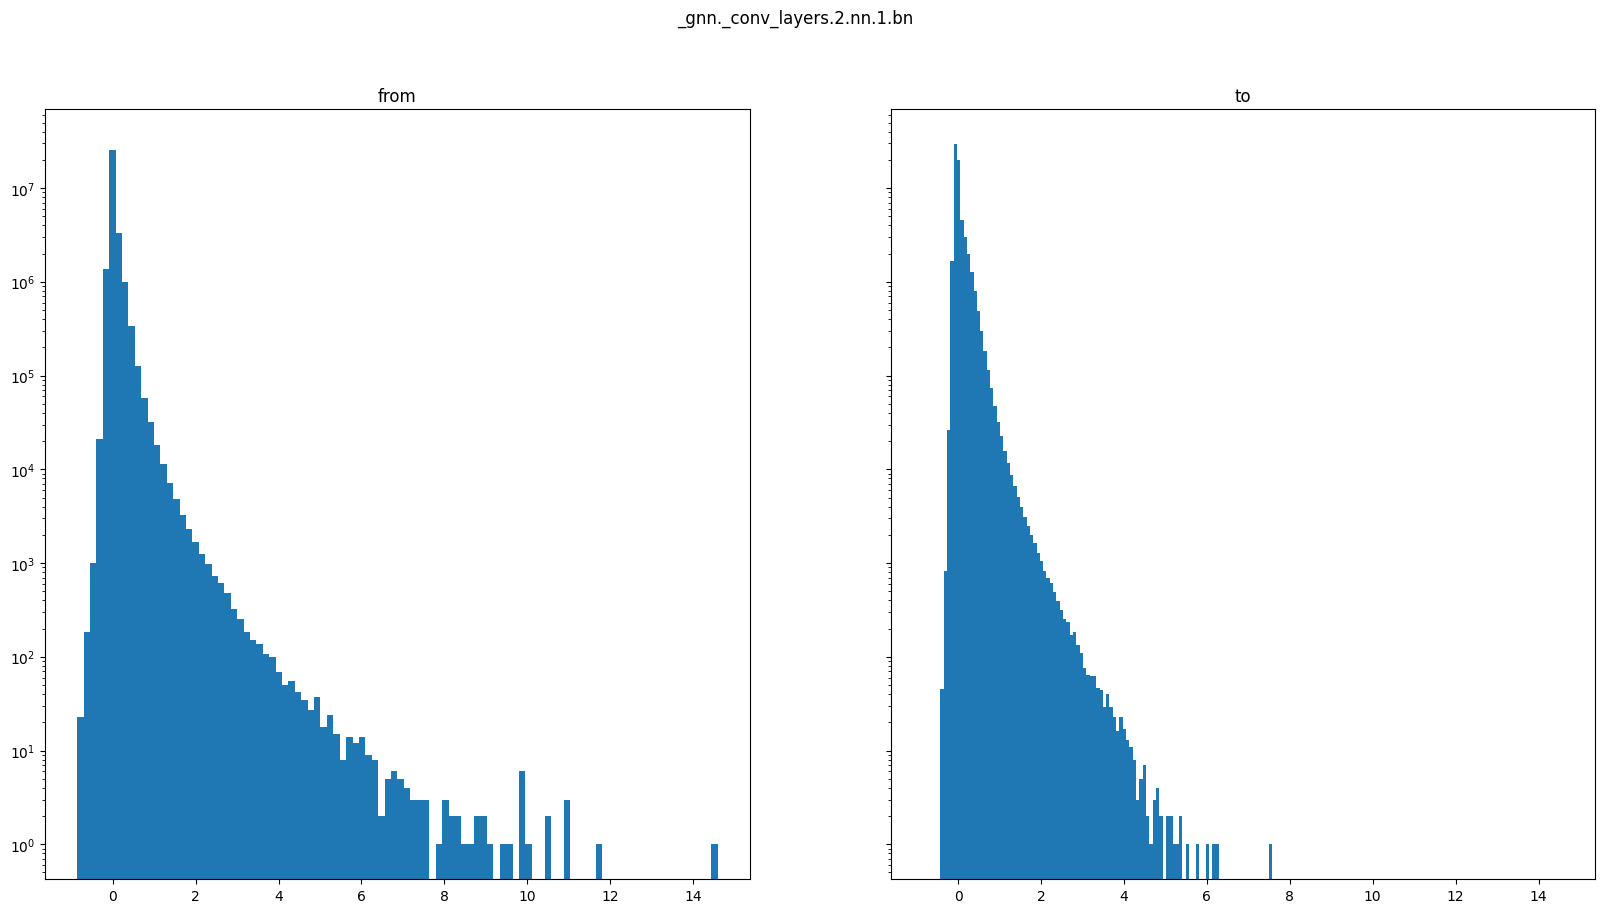

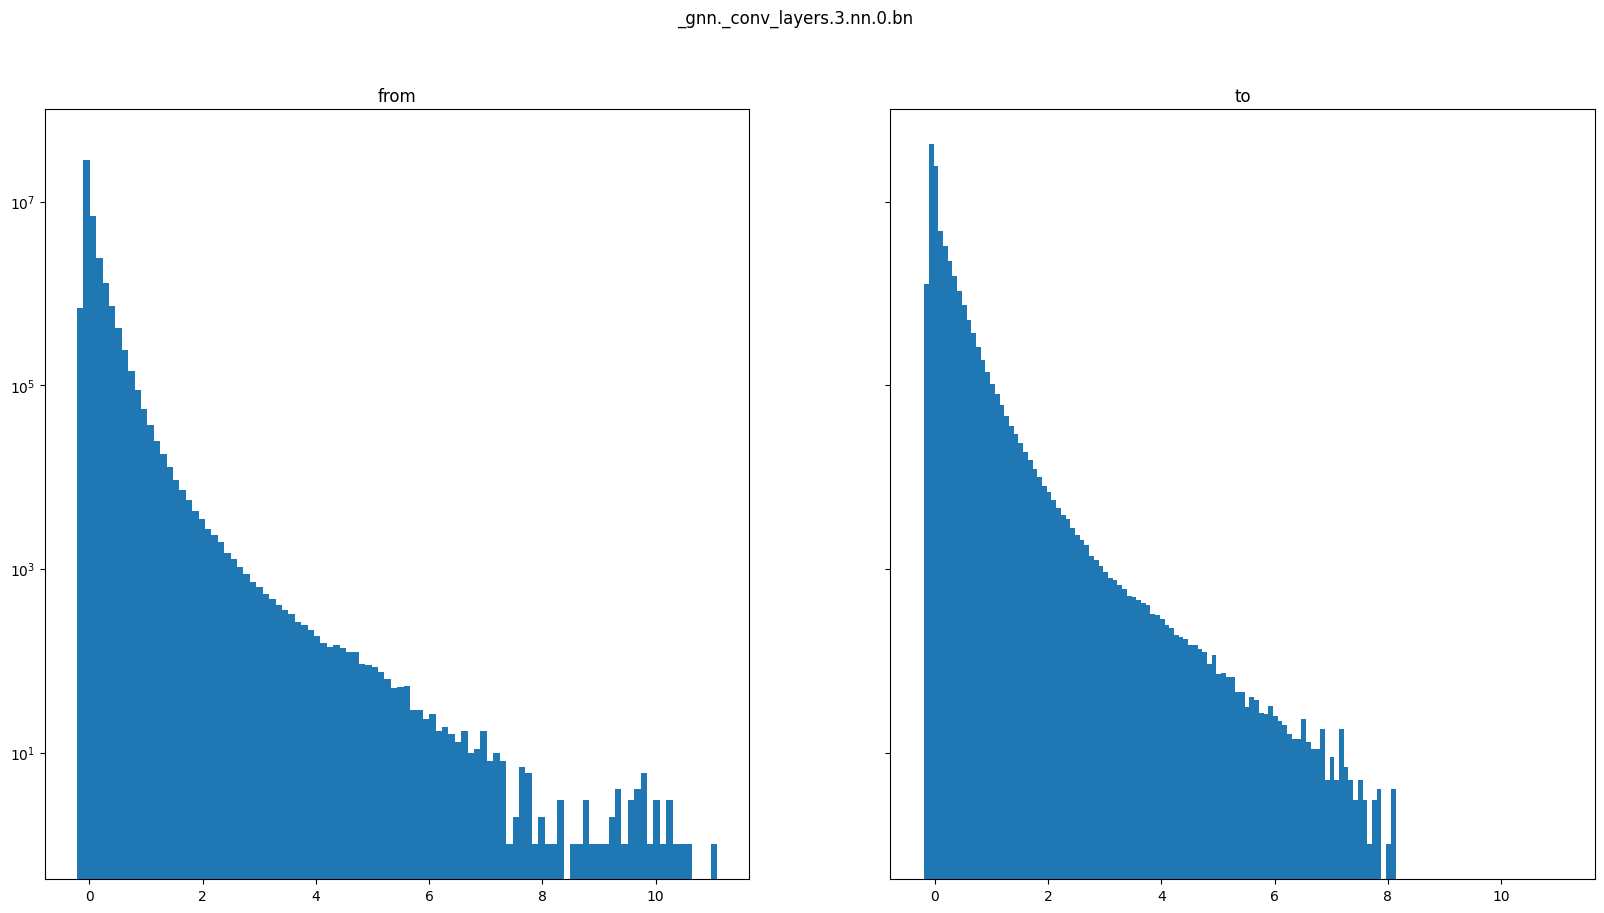

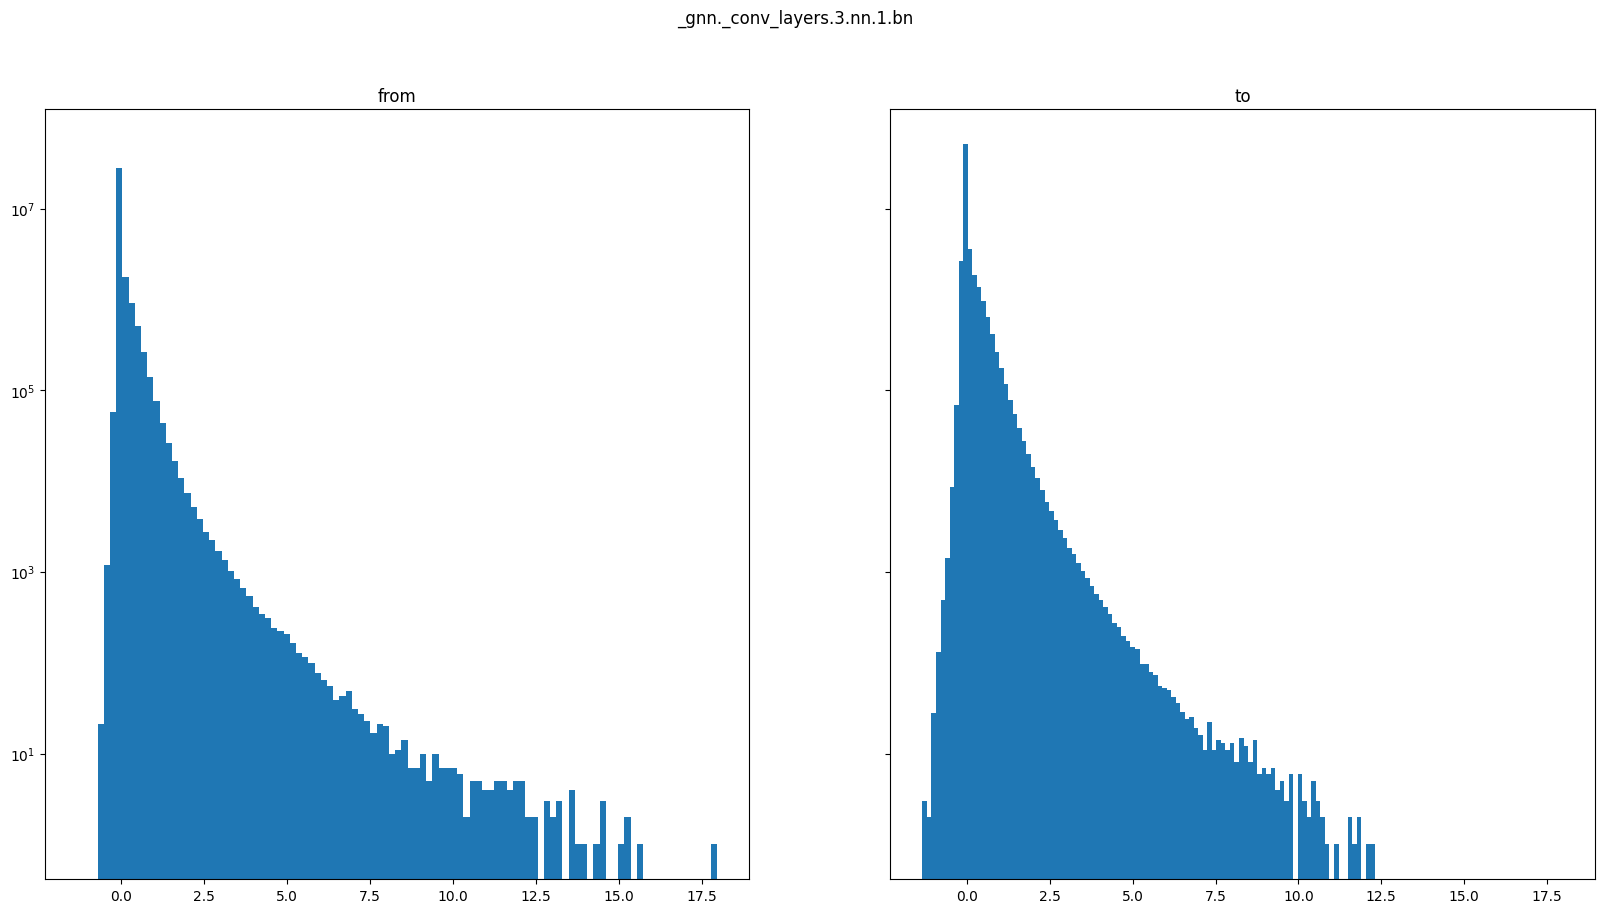

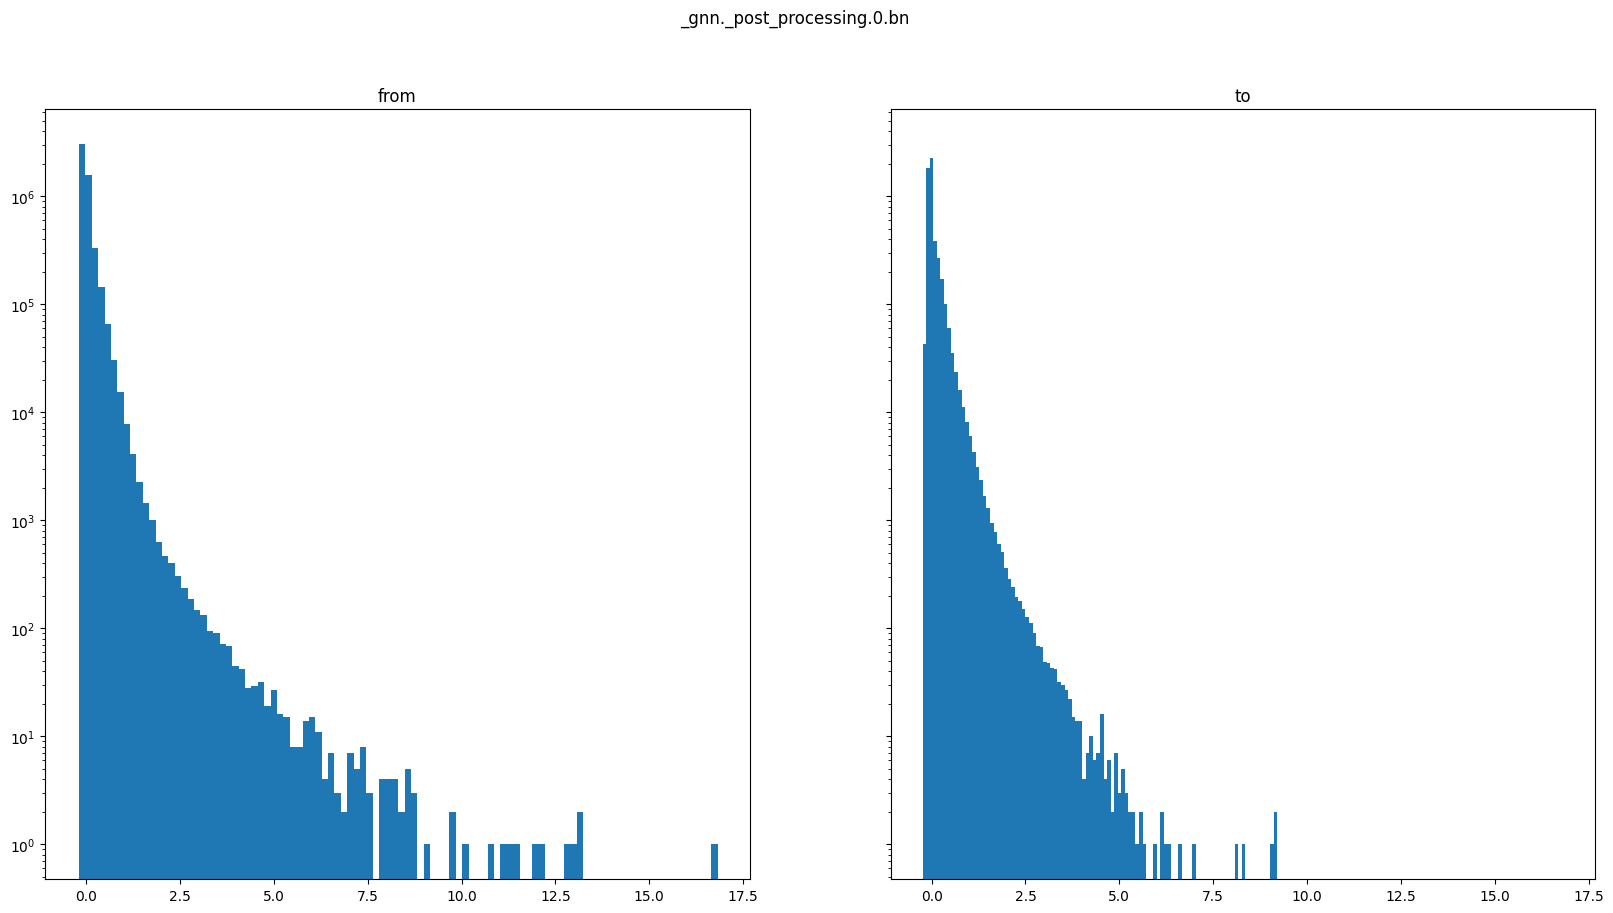

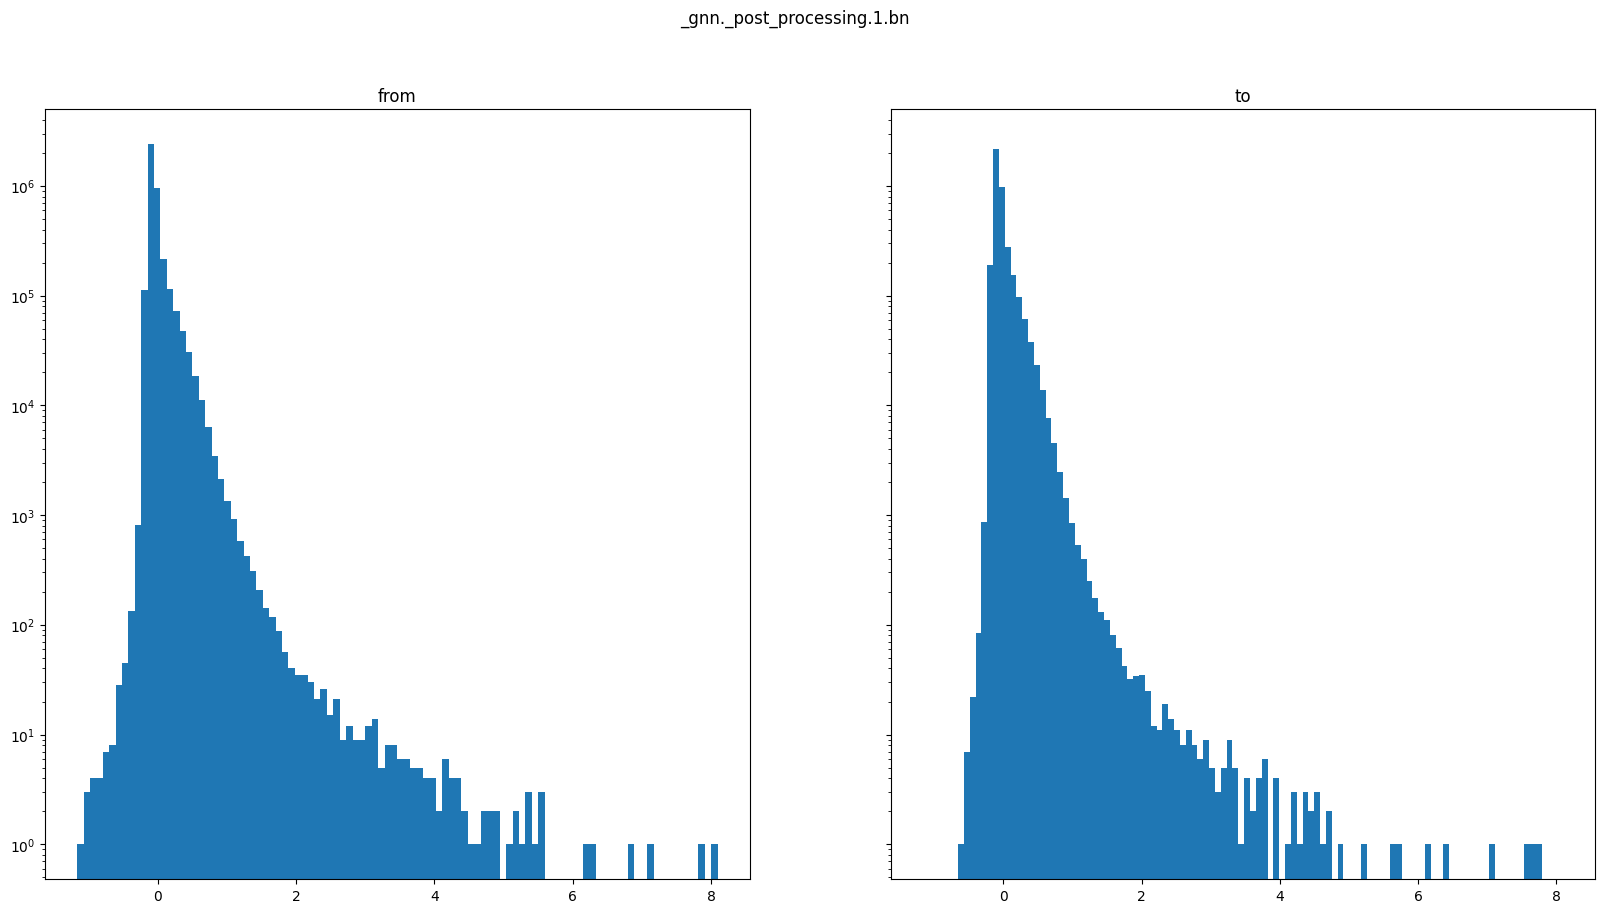

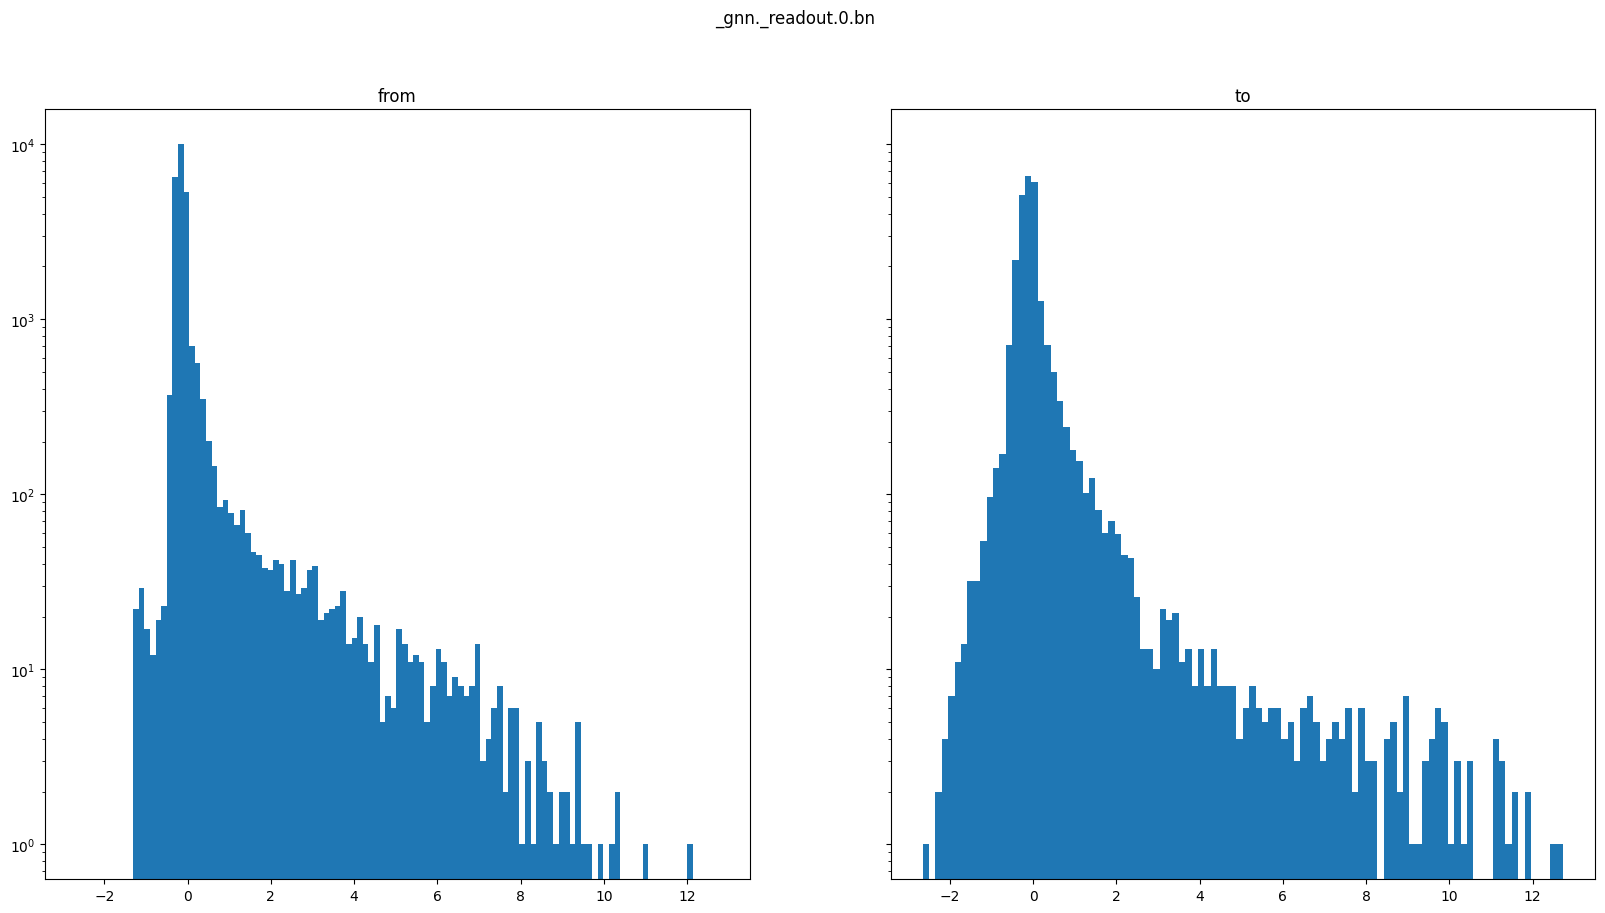

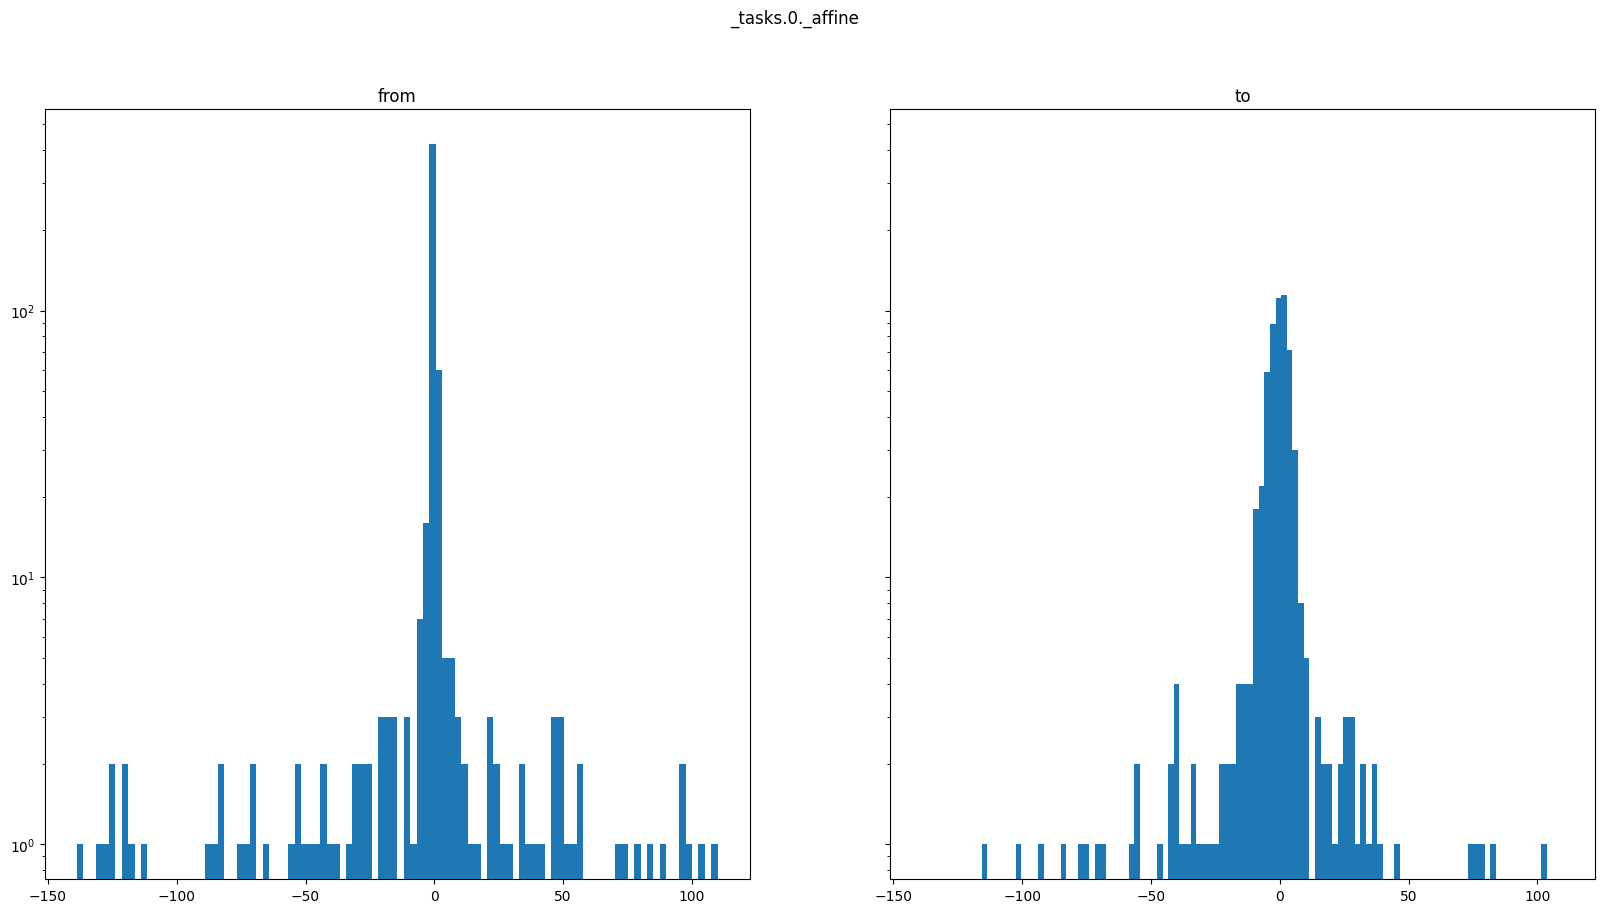

In [17]:
plt.close('all')
for ln, acts in zip(
    zip(*[activations[i].keys() for i in range(len(activations))]),
    zip(*[activations[i].values() for i in range(len(activations))])
):
    fig, axes = plt.subplots(1, len(acts), figsize=(20, 10), sharey=True, sharex=True)
    fig.suptitle(ln[0])
    print(ln[0], [a.shape for a in acts])
    print(ln[0], [a.min().item() for a in acts])
    print(ln[0], [a.max().item() for a in acts])
    a_std_rel = []
    for i, (model_name, a) in enumerate(zip(['from', 'to'], acts)):
        a_flattened = a.flatten().cpu().numpy()
        # if model_name == 'mapped' and ln[0] != '_gnn._conv_layers.0.nn.0':
        #     a_flattened = a_flattened / 0.7
        if i == 0:
            a_std_rel.append(1)
        else:
            a_std_rel.append(a_flattened.std() / a_std_rel[0])
        axes[i].hist(a_flattened, bins=100)
        axes[i].set_yscale('log')
        axes[i].set_title(model_name)
    print(ln[0], a_std_rel)
    print()